# 1. Set up Environment

In [108]:
#pip install torch

In [109]:
import os
import pandas as pd
import numpy as np
from importlib.machinery import SourceFileLoader
sets = SourceFileLoader('sets', 'C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/sets.py').load_module()
pytorch = SourceFileLoader('pytorch', 'C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/pytorch.py').load_module()
null = SourceFileLoader('null', 'C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/null.py').load_module()
train_classification_model = SourceFileLoader('train_classification_model', 'C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/train_classification_model.py').load_module()
test_classification_model = SourceFileLoader('test_classification_model', 'C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/test_classification_model.py').load_module()
performance = SourceFileLoader('performance', 'C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/performance.py').load_module()
import torch
import seaborn as sns
from matplotlib import pyplot

In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
print(torch.__version__)

1.13.1+cpu


In [112]:
pd.options.display.max_rows = 10000

In [113]:
# Download data from Kaggle API, unzip and place in data directory
os.environ['KAGGLE_USERNAME'] = "kallikrates"
os.environ['KAGGLE_KEY'] = "238b7c2704c0169326ee26d23a1d1d7c"
!kaggle datasets download -d kallikrates/adsi-at2
!unzip -q adsi-at2.zip -d /home/jovyan/work/data_files/raw

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


# 2. Load and Explore Data

In [114]:
df = pd.read_csv('C:/Users/Yatindra/Documents/ADSI/ADSI_AT2-master/data_files/raw/beer_reviews.csv')

In [115]:
df.shape

(1586614, 13)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [117]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


# 3. Prepare Data

In [118]:
df_cleaned = df.copy()

### Drop unused variables

In [119]:
df_cleaned = df_cleaned.drop(['brewery_id', 'review_time','review_profilename','beer_beerid','beer_name','beer_abv'], axis=1)

### Create Categorical Variable Dictionary

In [120]:
arr_brewery_name = df_cleaned.brewery_name.unique()
arr_beer_style = df_cleaned.beer_style.unique()

In [121]:
lst_brewery_name = list(arr_brewery_name)
lst_beer_style = list(arr_beer_style)

In [122]:
cats_dict = {
    'brewery_name': [lst_brewery_name],
    'beer_style': [lst_beer_style]
}

### Quantify NULL Values

In [123]:
df_cleaned.isnull().sum()

brewery_name         15
review_overall        0
review_aroma          0
review_appearance     0
beer_style            0
review_palate         0
review_taste          0
dtype: int64

In [124]:
df_cleaned.dropna(how='any', inplace=True)

### Transform Categorical column values with encoder and Scale with Scaler

In [125]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [126]:
for col, cats in cats_dict.items():
    col_encoder = OrdinalEncoder(categories=cats)
    df_cleaned[col] = col_encoder.fit_transform(df_cleaned[[col]])

In [127]:
num_cols = ['brewery_name','review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

In [128]:
target_col = 'beer_style'

In [129]:
sc = StandardScaler()

In [130]:
df_cleaned[num_cols] = sc.fit_transform(df_cleaned[num_cols])

In [131]:
df_cleaned['beer_style'] = df_cleaned['beer_style'].astype(int)

In [132]:
X = df_cleaned

In [133]:
X.describe()

,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste
count,1.586599e+06,1.586599e+06,1.586599e+06,1.586599e+06,1.586599e+06,1.586599e+06,1.586599e+06
mean,7.510541e-13,-7.591916e-14,2.642430e-14,1.524473e-13,3.318427e+01,-6.920609e-14,2.124292e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.552354e+01,1.000000e+00,1.000000e+00
min,-1.658902e+00,-5.294872e+00,-3.921421e+00,-6.235533e+00,0.000000e+00,-4.021772e+00,-3.815568e+00
25%,-8.812362e-01,-4.379353e-01,-3.377775e-01,-5.545413e-01,1.300000e+01,-3.572271e-01,-4.001069e-01
50%,-4.116536e-02,2.559127e-01,3.789512e-01,2.570289e-01,2.500000e+01,3.756820e-01,2.829853e-01
75%,8.409090e-01,9.497608e-01,3.789512e-01,2.570289e-01,5.300000e+01,3.756820e-01,9.660776e-01
max,1.786589e+00,1.643609e+00,1.812409e+00,1.880169e+00,1.030000e+02,1.841500e+00,1.649170e+00


### Visualise Target Class Distribution

<AxesSubplot:xlabel='beer_style', ylabel='count'>

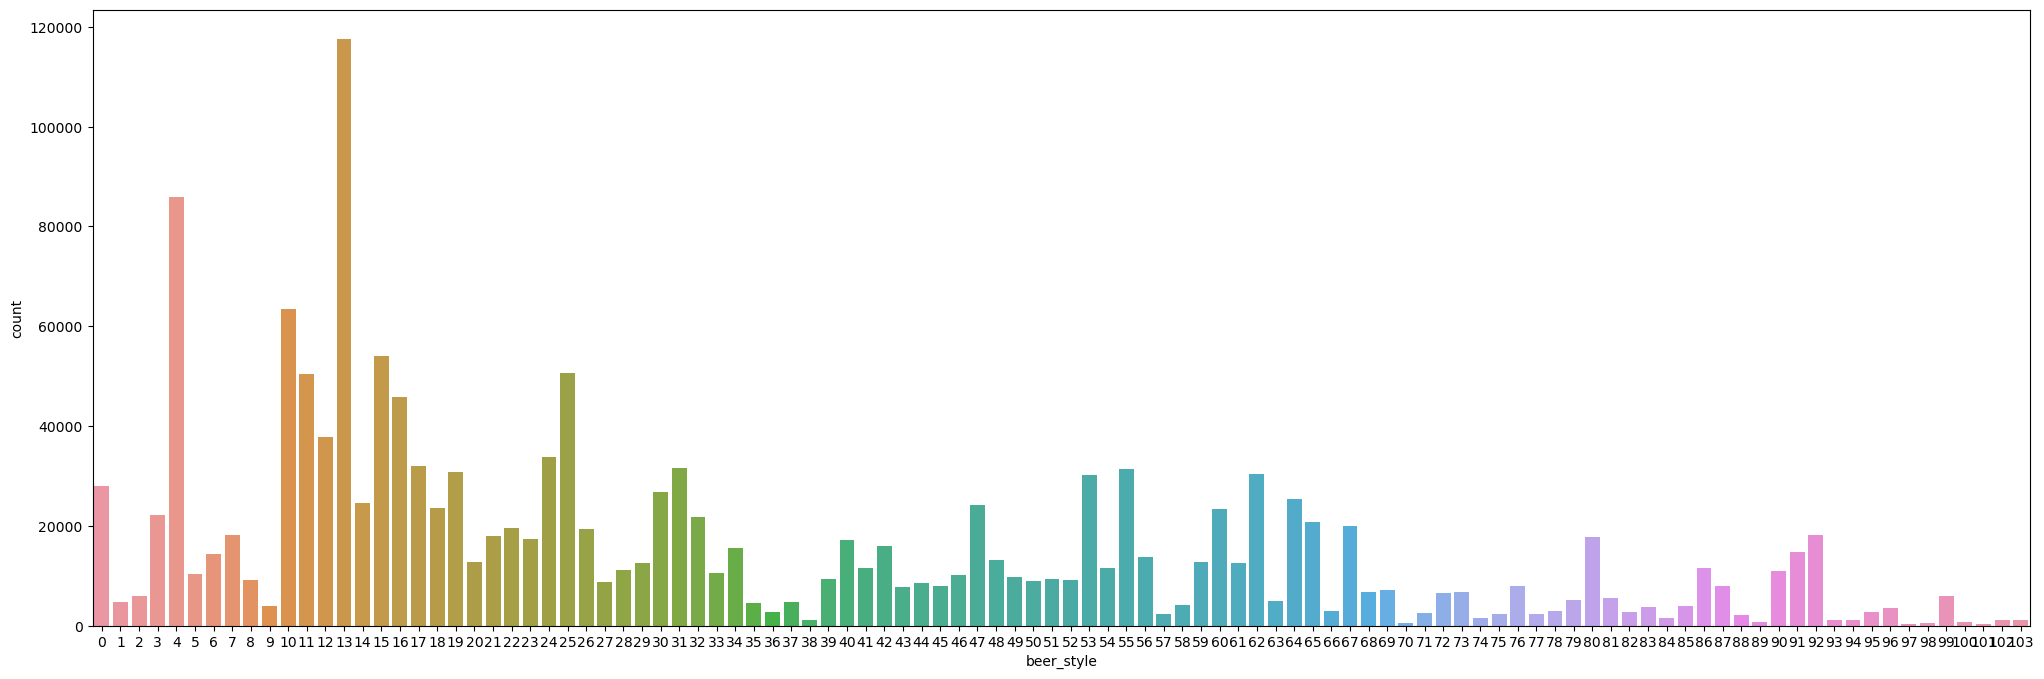

In [134]:
a4_dims = (25, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x = 'beer_style', data=X)

### Split Data

In [135]:
from sets import split_sets_by_time, save_sets, split_sets_random

In [136]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets_random(X, target_col=target_col, test_ratio=0.2, to_numpy=True)

In [137]:
save_sets(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, path='C:/Users/Yatindra/Documents/ADSI/ADSI_AT2-master/data_files/processed')

In [138]:
from pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

# 4. Model

In [139]:
from null import NullModel

In [140]:
baseline_model = NullModel(target_type='classification')
y_base = baseline_model.fit_predict(y_train)

C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/python/null.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred_value = mode(y)[0][0]


In [141]:
from performance import print_class_perf

In [142]:
print_class_perf(y_base, y_train, set_name='Training', average='weighted')

Accuracy Training: 0.07430256975352931
F1 Training: 0.01027805764859095


# 5. Define Architecture

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [144]:
from pytorch import PytorchMultiClass

model = PytorchMultiClass(X_train.shape[1])

In [145]:
from pytorch import get_device

device = get_device()
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=6, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

# 6. Train Model

In [146]:
criterion = nn.CrossEntropyLoss()

In [147]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [148]:
from train_classification_model import train_classification
from test_classification_model import test_classification

In [149]:
N_EPOCHS = 2
BATCH_SIZE = 32

In [150]:
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: 0.1449	|	Acc: 4.2%
Epoch: 1
	(train)	|	Loss: 0.1439	|	Acc: 7.4%


In [151]:
test_loss, test_acc = test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:.4f}\t|\tAccuracy: {test_acc:.1f}')

	Loss: 0.1435	|	Accuracy: 0.1


In [152]:
torch.save(model.state_dict(), "C:/Users/Yatindra/Documents/ADSI/AT2_ADSI-master/models/pytorch_multi_beer_evaluation.pt")

In [153]:
print(model.eval())

PytorchMultiClass(
  (layer_1): Linear(in_features=6, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)
